# Calibrate cameras, create initial orthoimage and partial DSM

In [6]:
import os
from glob import glob
import subprocess
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import rioxarray as rxr
from shapely.geometry import Point
import geopandas as gpd
import pyproj
# Ignore warnings (rasterio throws a warning whenever an image is not georeferenced. Annoying in this case.)
import warnings
warnings.filterwarnings('ignore')

# Define input image files
data_folder = '/Users/rdcrlrka/Research/Soo_locks'
img_folder = os.path.join(data_folder, '20251001_imagery', 'frames_IR')
img_list = sorted(glob(os.path.join(img_folder, '*.tiff')))
print(f"{len(img_list)} images located")

# Grab standard input files
refdem_file = os.path.join(os.getcwd(), '..', 'inputs', '20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif')
gcp_folder = os.path.join(os.getcwd(), '..', 'inputs', 'gcp')
cams_file = os.path.join(os.getcwd(), '..', 'inputs', 'cams_lonlat-fake.txt')

# Define output folders
out_folder = img_folder + '_proc_out'
os.makedirs(out_folder, exist_ok=True)
new_img_folder = os.path.join(out_folder, 'single_band_images')
undistorted_folder = os.path.join(out_folder, 'undistorted_images')
ortho_folder = os.path.join(out_folder, 'ortho')
stereo_folder = os.path.join(out_folder, 'stereo')


16 images located


## Convert images to single band in case they're RGB

A couple IR images (near the windows) were captured in RGB 

In [7]:
os.makedirs(new_img_folder, exist_ok=True)

# iterate over images
print('Saving single-band images to:', new_img_folder)
for img_fn in tqdm(img_list[0:8]):
    # convert images to single band
    out_fn = os.path.join(new_img_folder, os.path.basename(img_fn))
    if os.path.exists(out_fn):
        continue
    cmd = [
        "gdal_translate",
        "-b", "1",
        img_fn, out_fn
    ]
    subprocess.run(cmd)

Saving single-band images to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/single_band_images


100%|██████████| 8/8 [00:00<00:00, 9399.00it/s]


## Undistort images using GCP

In [ ]:
def opencv_to_tsai(K, rvec, tvec, object_points_mean, utm_crs="EPSG:32619"):
    """
    Convert an OpenCV camera to APS-compatible TSAI format in ECEF.

    Parameters
    ----------
    K : np.ndarray (3x3)
        OpenCV intrinsic matrix.
    rvec : np.ndarray (3x1)
        OpenCV rotation vector (world -> camera).
    tvec : np.ndarray (3x1)
        OpenCV translation vector (world -> camera) in UTM meters.
    object_points_mean: np.ndarray (3,)
        Mean of the object points used in solvePnP (to restore absolute position)
    utm_crs : str
        CRS of the camera / object points (default EPSG:32619).

    Returns
    -------
    tsai_dict : dict
        TSAI camera parameters ready for ASP, with `C` in ECEF.
    """

    # Compute rotation matrix camera -> world in UTM
    R_wc = cv2.Rodrigues(rvec)[0]   # world -> camera
    R_cw = R_wc.T                   # camera -> world (UTM)

    # Compute camera center in UTM coordinates
    C_utm = -R_cw @ tvec.reshape(3) + object_points_mean.reshape(3)

    # Transform C to ECEF
    transformer = pyproj.Transformer.from_crs(utm_crs, "EPSG:4978", always_xy=True)
    X_ecef, Y_ecef, Z_ecef = transformer.transform(C_utm[0], C_utm[1], C_utm[2])
    C_ecef = np.array([X_ecef, Y_ecef, Z_ecef])

    # Compute rotation from camera -> ECEF
    # Transform the UTM axes directions to ECEF at the camera location
    # We'll use a small delta along UTM axes to compute approximate ECEF rotation
    delta = 1.0  # 1 meter
    pts_utm = np.array([
        C_utm,
        C_utm + R_cw[:,0]*delta,  # X axis
        C_utm + R_cw[:,1]*delta,  # Y axis
        C_utm + R_cw[:,2]*delta   # Z axis
    ])

    # Transform these points to ECEF
    ecef_pts = np.array([transformer.transform(x,y,z) for x,y,z in pts_utm])
    # Build new axes in ECEF
    X_axis = ecef_pts[1] - ecef_pts[0]
    Y_axis = ecef_pts[2] - ecef_pts[0]
    Z_axis = ecef_pts[3] - ecef_pts[0]

    # Normalize axes
    X_axis /= np.linalg.norm(X_axis)
    Y_axis /= np.linalg.norm(Y_axis)
    Z_axis /= np.linalg.norm(Z_axis)

    R_ecef = np.stack([X_axis, Y_axis, Z_axis], axis=1)  # camera -> ECEF

    # Build TSAI dictionary
    tsai_dict = {
        'VERSION': 4,
        'TYPE': 'PINHOLE',
        'fu': float(K[0,0]),
        'fv': float(K[1,1]),
        'cu': float(K[0,2]),
        'cv': float(K[1,2]),
        'u_direction': np.array([1,0,0]),
        'v_direction': np.array([0,1,0]),
        'w_direction': np.array([0,0,1]),
        'C': C_ecef.astype(float),
        'R': R_ecef.astype(float),
        'pitch': 1
    }

    return tsai_dict


def save_tsai(tsai_dict, filename):
    """
    Save a TSAI (.tsai) pinhole camera file from a dictionary.
    """
    with open(filename, 'w') as f:
        f.write("VERSION_4\n")
        f.write("PINHOLE\n")
        f.write(f"fu = {tsai_dict['fu']}\n")
        f.write(f"fv = {tsai_dict['fv']}\n")
        f.write(f"cu = {tsai_dict['cu']}\n")
        f.write(f"cv = {tsai_dict['cv']}\n")
        f.write(f"u_direction = {' '.join(map(str, tsai_dict['u_direction']))}\n")
        f.write(f"v_direction = {' '.join(map(str, tsai_dict['v_direction']))}\n")
        f.write(f"w_direction = {' '.join(map(str, tsai_dict['w_direction']))}\n")
        f.write(f"C = {' '.join(map(str, tsai_dict['C']))}\n")
        # Flatten R for one-line APS format
        f.write("R = " + " ".join(map(str, tsai_dict['R'].flatten())) + "\n")
        f.write(f"pitch = {tsai_dict['pitch']}\n")
        f.write("NULL\n")


def undistort_align_camera(image_file, gcp_file, output_folder, plot_results=True):
    
    img_name = os.path.basename(image_file)

    # --- Load GCP file ---
    gcp = pd.read_csv(
        gcp_file,
        sep=', ',
        header=None,
        skiprows=[0],
        engine='python',
        names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std',
                'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z']
    )
    # reproject GCP to UTM (EPSG:32619)
    gcp['geometry'] = [Point(x, y) for x, y in gcp[['X', 'Y']].values]
    gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:4326")
    gcp_gdf = gcp_gdf.to_crs("EPSG:32619")
    gcp['X'] = gcp_gdf.geometry.x
    gcp['Y'] = gcp_gdf.geometry.y
    # make sure there are enough points
    if len(gcp) < 6:
        print(f"Skipping {img_name}: only {len(gcp)} GCPs found. At least 6 needed.")
        return

    # --- Prepare object and image points ---
    object_points = gcp[["X", "Y", "Z"]].values.astype(np.float32)
    # center around origin
    object_points_mean = object_points.mean(axis=0)
    object_points -= object_points_mean
    image_points = gcp[["sample_col", "sample_row"]].values.astype(np.float32)
    if len(object_points) == 0:
        raise ValueError("No valid GCPs found for any images.")
    
    # --- Read the image ---
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to read {image_file}, skipping.")
        return

    # --- Calibrate camera ---
    fx = fy = 2000
    cx = img.shape[1] / 2
    cy = img.shape[0] / 2
    K_init = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
        ], dtype=np.float64)
    dist_init = np.zeros(5)
    flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_ZERO_TANGENT_DIST
    )
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        [object_points],
        [image_points],
        (img.shape[1], img.shape[0]),
        K_init,
        dist_init,
        flags=flags
    )
    print("Calibration complete.")
    print("RMS reprojection error:", ret)
    print("Camera Matrix (K):\n", K)
    print("Distortion Coefficients:", dist.ravel())

    # --- Undistort the image and the GCP ---
    # Undistort the image
    img_undistorted = cv2.undistort(img, K, dist)
    # Calculate new GCP pixel indices for the undistorted image
    img_pts = gcp[['sample_col', 'sample_row']].values.astype(np.float32).reshape(-1, 1, 2)
    undistorted_pts = cv2.undistortPoints(img_pts, K, dist, P=K).reshape(-1, 2)
    gcp['sample_col_undist'] = undistorted_pts[:, 0]
    gcp['sample_row_undist'] = undistorted_pts[:, 1]
    # Plot results
    if plot_results:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        ax[0].imshow(img, cmap='gray')
        ax[0].plot(gcp['sample_col'], gcp['sample_row'], 'xr',
                markersize=5, linewidth=1.5)
        ax[0].set_title('Original')
        ax[1].imshow(img_undistorted, cmap='gray')
        ax[1].plot(gcp['sample_col_undist'], gcp['sample_row_undist'], 'xr',
                markersize=5, linewidth=1.5)
        ax[1].set_title('Undistorted')
        for axis in ax:
            axis.set_xticks([]), axis.set_yticks([])
        plt.suptitle(img_name)
        plt.tight_layout()

        # save to file
        fig_fn = os.path.join(output_folder, os.path.splitext(img_name)[0] + '_undistorted.png')
        fig.savefig(fig_fn, dpi=300, bbox_inches='tight')

        plt.close()

    # --- Save results to file ---
    # Save undistorted image as GeoTIFF
    img_undistorted_file = os.path.join(output_folder, os.path.splitext(img_name)[0] + '_undistorted.tiff')
    img_xr = rxr.open_rasterio(image_file).squeeze()
    img_undistorted_xr = img_xr.copy()
    img_undistorted_xr.data = img_undistorted
    img_undistorted_xr.rio.to_raster(img_undistorted_file)
    print('Saved undistorted raster to:', img_undistorted_file)

    # Reformat GCP for saving
    # reproject to lat-lon (fake)
    gcp['geometry'] = [Point(x,y) for x,y in gcp[['X','Y']].values]
    gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:32619")
    gcp_gdf = gcp_gdf.to_crs("EPSG:4326")
    gcp['X'] = [x.coords.xy[0][0] for x in gcp_gdf['geometry']]
    gcp['Y'] = [x.coords.xy[1][0] for x in gcp_gdf['geometry']]
    # update the image name
    gcp['img_name'] = [os.path.basename(x).replace('.tiff', '_undistorted.tiff') for x in gcp['img_path']]
    # select the appropriate rows in order
    gcp['sample_col'] = gcp['sample_col_undist']
    gcp['sample_row'] = gcp['sample_row_undist']
    gcp = gcp[['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std', 'img_name', 'sample_col', 'sample_row', 'use_Y', 'use_X']]

    # Save undistorted GCP as CSV        
    gcp_undistorted_file = os.path.join(output_folder, os.path.splitext(os.path.basename(gcp_file))[0] + '_undistorted.gcp')
    gcp.to_csv(
        gcp_undistorted_file, 
        sep=',', 
        index=False,
        header=False
        )
    print('Saved undistorted GCP to:', gcp_undistorted_file)

    # Save camera as Ames Stereo Pipeline pinhole model
    tsai_file = os.path.join(output_folder, os.path.splitext(img_name)[0] + '_undistorted.tsai')
    tsai_dict = opencv_to_tsai(K, rvecs[0], tvecs[0], object_points_mean)
    save_tsai(tsai_dict, tsai_file)
    print('Saved pinhole camera model to:', tsai_file)

    return


os.makedirs(undistorted_folder, exist_ok=True)

image_list = sorted(glob(os.path.join(new_img_folder, '*.tiff')))
gcp_list = sorted(glob(os.path.join(gcp_folder, '*.gcp')))

for image_file, gcp_file in tqdm(list(zip(image_list[0:6], gcp_list[0:6]))):
    print(f"\nUndistorting and aligning {os.path.basename(image_file)}")
    undistort_align_camera(image_file, gcp_file, undistorted_folder, plot_results=True)


  0%|          | 0/6 [00:00<?, ?it/s]


Undistorting and aligning N910A6_ch01_main_20251001180000_20251001180626.tiff
Calibration complete.
RMS reprojection error: 20.405466904916604
Camera Matrix (K):
 [[4.53861457e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 4.54716278e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [-1.41116822  2.64934061  0.          0.         -2.66734994]


 17%|█▋        | 1/6 [00:01<00:09,  1.83s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tsai

Undistorting and aligning N910A6_ch02_main_20251001180001_20251001180626.tiff
Calibration complete.
RMS reprojection error: 27.64616232650137
Camera Matrix (K):
 [[3.18207360e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 3.19795718e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [-0.22165478 -1.39886109  0.          0.          2.06763723]


 33%|███▎      | 2/6 [00:03<00:07,  1.82s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.tsai

Undistorting and aligning N910A6_ch03_main_20251001180002_20251001180626.tiff
Calibration complete.
RMS reprojection error: 13.209164594395283
Camera Matrix (K):
 [[1.63647686e+04 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 1.63965389e+04 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [   -22.72839717    837.68470777      0.              0.
 -14459.95211353]


 50%|█████     | 3/6 [00:05<00:05,  1.82s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch03_main_20251001180002_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch03_main_20251001180002_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch03_main_20251001180002_20251001180626_undistorted.tsai

Undistorting and aligning N910A6_ch04_main_20251001180003_20251001180626.tiff
Calibration complete.
RMS reprojection error: 24.09446787324862
Camera Matrix (K):
 [[3.88987214e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 3.92386319e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [-1.62805304  4.74798295  0.          0.         -5.70650639]


 67%|██████▋   | 4/6 [00:07<00:03,  1.78s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch04_main_20251001180003_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch04_main_20251001180003_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch04_main_20251001180003_20251001180626_undistorted.tsai

Undistorting and aligning N910A6_ch05_main_20251001180004_20251001180626.tiff
Calibration complete.
RMS reprojection error: 21.02769879160565
Camera Matrix (K):
 [[9.16954154e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 9.07174365e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [  -6.9707099    98.45177484    0.            0.         -656.86774248]


 83%|████████▎ | 5/6 [00:09<00:01,  1.80s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch05_main_20251001180004_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch05_main_20251001180004_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch05_main_20251001180004_20251001180626_undistorted.tsai

Undistorting and aligning N910A6_ch06_main_20251001180005_20251001180626.tiff
Calibration complete.
RMS reprojection error: 22.795911956803643
Camera Matrix (K):
 [[4.50757166e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 4.54994636e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients: [-1.70094276  5.71032253  0.          0.         -8.91587029]


100%|██████████| 6/6 [00:10<00:00,  1.81s/it]

Saved undistorted raster to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch06_main_20251001180005_20251001180626_undistorted.tiff
Saved undistorted GCP to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch06_main_20251001180005_20251001180626_undistorted.gcp
Saved pinhole camera model to: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch06_main_20251001180005_20251001180626_undistorted.tsai


In [22]:
### SOLVE INTRINSICS ALL IN ONE, THEN EXTRINSICS ON A PER-CAMERA BASIS ###

def calibrate_shared_intrinsics(image_files, gcp_files, min_gcp=6, num_coef=8):
    """
    Calibrate a shared intrinsic K and distortion using all images.
    Returns K, dist, object_points_mean
    """
    object_points_list = []
    image_points_list = []
    image_size = None

    for image_file, gcp_file in zip(image_files, gcp_files):
        # Load GCP
        gcp = pd.read_csv(
            gcp_file,
            sep=', ',
            header=None,
            skiprows=[0],
            engine='python',
            names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std',
                   'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z']
        )
        gcp['geometry'] = [Point(x,y) for x,y in gcp[['X','Y']].values]
        gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:4326").to_crs("EPSG:32619")
        gcp['X'] = gcp_gdf.geometry.x
        gcp['Y'] = gcp_gdf.geometry.y
        if len(gcp) < min_gcp:
            print(f"Skipping {image_file}: not enough GCPs")
            continue

        # Object and image points
        obj_pts = gcp[['X','Y','Z']].values.astype(np.float32)
        img_pts = gcp[['sample_col','sample_row']].values.astype(np.float32)
        obj_pts = obj_pts.reshape(-1,1,3)
        img_pts = img_pts.reshape(-1,1,2)

        object_points_list.append(obj_pts)
        image_points_list.append(img_pts)

        # get image size
        if image_size is None:
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image_size = (img.shape[1], img.shape[0])

    if len(object_points_list) == 0:
        raise ValueError("No valid images for calibration")

    # Initialize K
    fx = fy = 2000
    cx = image_size[0] / 2
    cy = image_size[1] / 2
    K_init = np.array([
        [fx,0,cx],
        [0,fy,cy],
        [0,0,1]
        ], dtype=np.float64)
    dist_init = np.zeros(num_coef)
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS 
             | cv2.CALIB_FIX_PRINCIPAL_POINT 
             | cv2.CALIB_ZERO_TANGENT_DIST
             | cv2.CALIB_RATIONAL_MODEL
             )

    # Calibrate
    ret, K, dist, _, _ = cv2.calibrateCamera(
        object_points_list,
        image_points_list,
        image_size,
        K_init,
        dist_init,
        flags=flags
    )

    # Compute mean of all object points
    all_obj_pts = np.vstack([op.reshape(-1,3) for op in object_points_list])
    object_points_mean = all_obj_pts.mean(axis=0)

    print("Shared calibration done")
    print("RMS reprojection error:", ret)
    print("Camera matrix K:\n", K)
    print("Distortion coefficients:", dist.ravel())

    return K, dist, object_points_mean

def process_image(image_file, gcp_file, K, dist, object_points_mean, output_folder):
    """
    Undistort image, compute per-image rvec/tvec, save TSAI and undistorted image
    """
    img_name = os.path.basename(image_file)
    gcp = pd.read_csv(
        gcp_file,
        sep=', ',
        header=None,
        skiprows=[0],
        engine='python',
        names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std',
               'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z']
    )
    gcp['geometry'] = [Point(x,y) for x,y in gcp[['X','Y']].values]
    gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:4326").to_crs("EPSG:32619")
    gcp['X'] = gcp_gdf.geometry.x
    gcp['Y'] = gcp_gdf.geometry.y

    # Object points mean-centered
    obj_pts = gcp[['X','Y','Z']].values.astype(np.float32) - object_points_mean
    img_pts = gcp[['sample_col','sample_row']].values.astype(np.float32)

    # SolvePnP for per-image extrinsics
    success, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K, dist, flags=cv2.SOLVEPNP_ITERATIVE)
    if not success:
        raise RuntimeError(f"solvePnP failed for {image_file}")

    # Undistort
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    img_undistorted = cv2.undistort(img, K, dist)

    # Save TSAI
    tsai_file = os.path.join(output_folder, os.path.splitext(img_name)[0] + '_undistorted.tsai')
    tsai_dict = opencv_to_tsai(K, rvec, tvec, object_points_mean)
    save_tsai(tsai_dict, tsai_file)
    print(f"Saved TSAI: {tsai_file}")

    # Save undistorted image
    img_undist_file = os.path.join(output_folder, os.path.splitext(img_name)[0] + '_undistorted.tiff')
    cv2.imwrite(img_undist_file, img_undistorted)
    print(f"Saved undistorted image: {img_undist_file}")


os.makedirs(undistorted_folder, exist_ok=True)
image_list = sorted(glob(os.path.join(new_img_folder, '*.tiff')))
gcp_list = sorted(glob(os.path.join(gcp_folder, '*.gcp')))

# Step 1: shared calibration
K, dist, object_points_mean = calibrate_shared_intrinsics(image_list, gcp_list)

# Step 2: per-image processing
for image_file, gcp_file in zip(image_list[0:6], gcp_list[0:6]):
    process_image(image_file, gcp_file, K, dist, object_points_mean, undistorted_folder)

Shared calibration done
RMS reprojection error: 24.362544505806454
Camera matrix K:
 [[4.43170618e+03 0.00000000e+00 1.92000000e+03]
 [0.00000000e+00 4.44673823e+03 1.08000000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients: [ -0.19348737 -13.950475     0.           0.          19.66729869
   1.84400133 -22.37887499  27.70918498   0.           0.
   0.           0.           0.           0.        ]
Saved TSAI: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tsai
Saved undistorted image: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tiff
Saved TSAI: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.tsai
Saved undistorted image: /Users/rdcrlrka/Research/Soo_lo

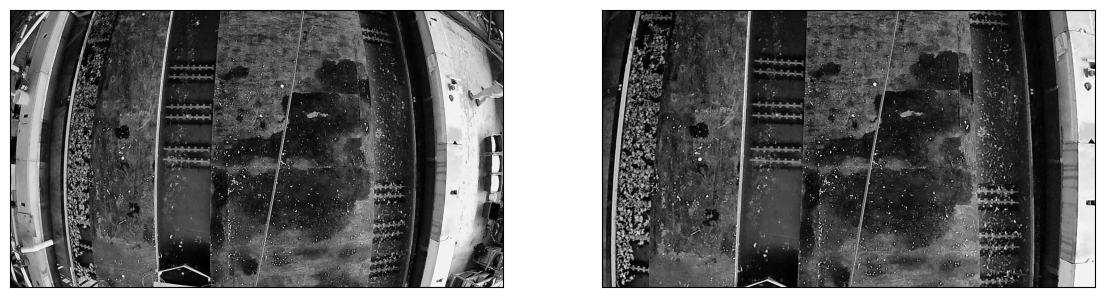

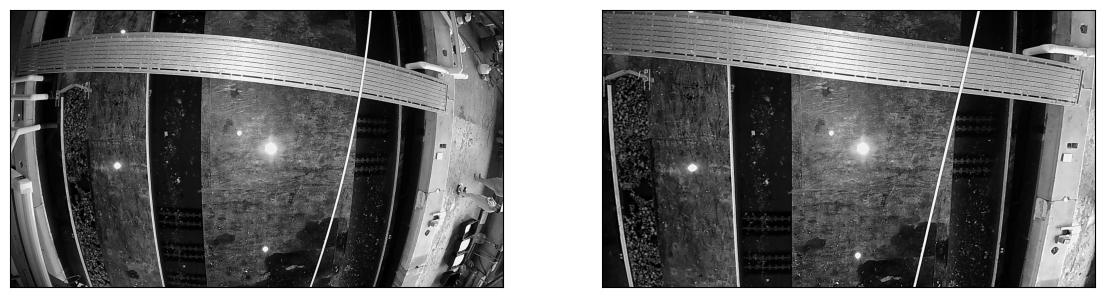

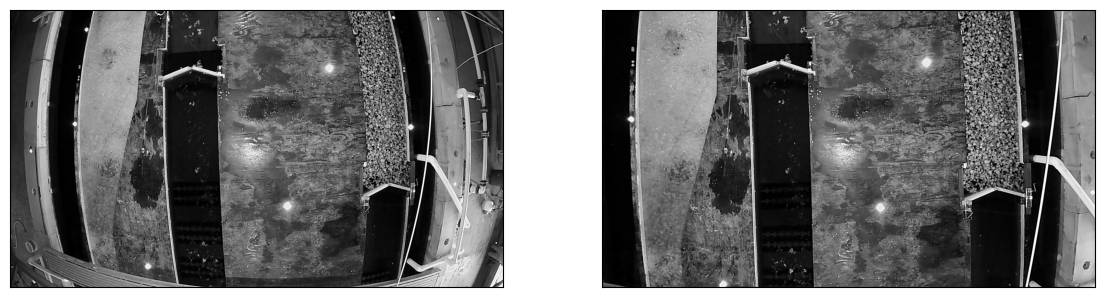

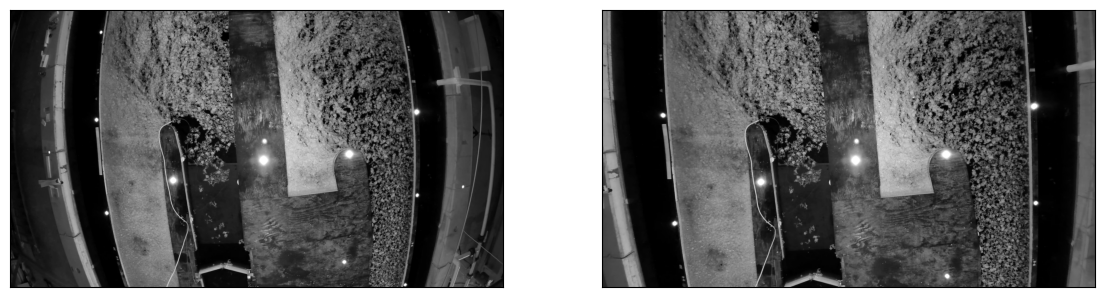

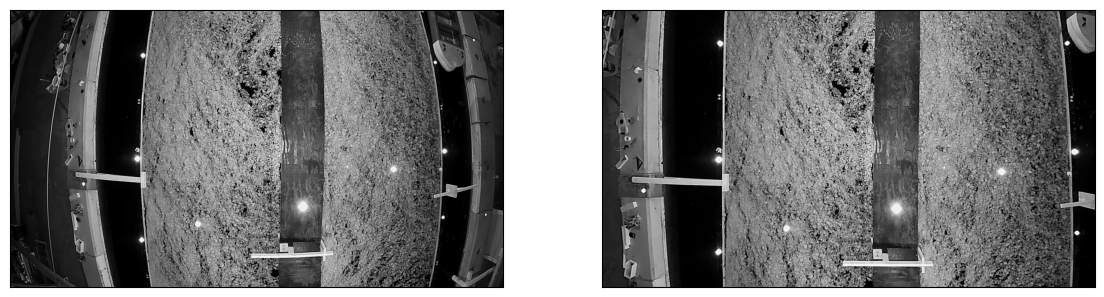

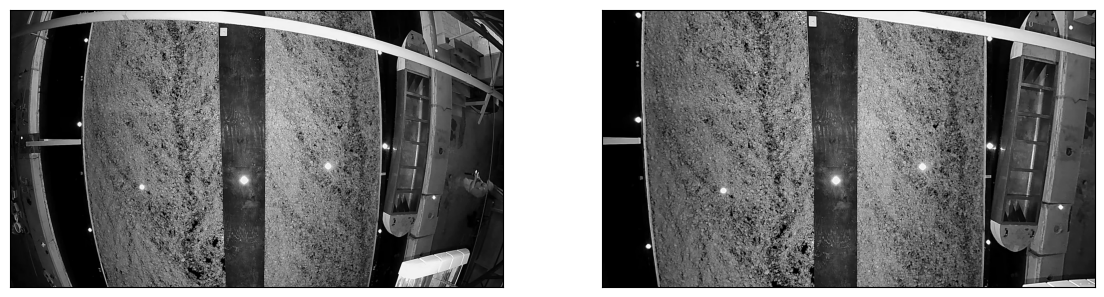

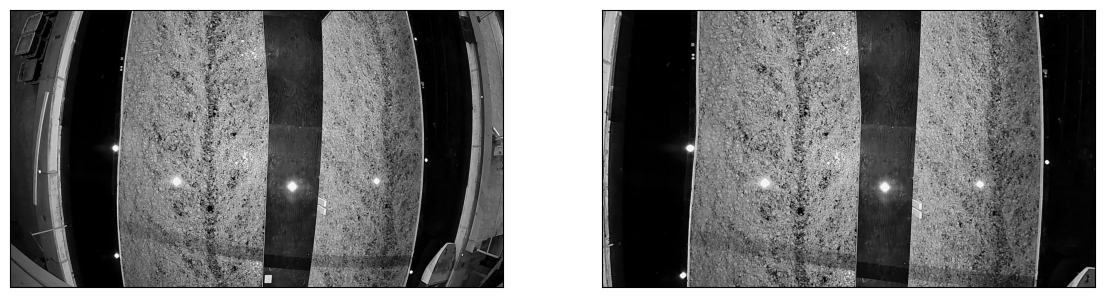

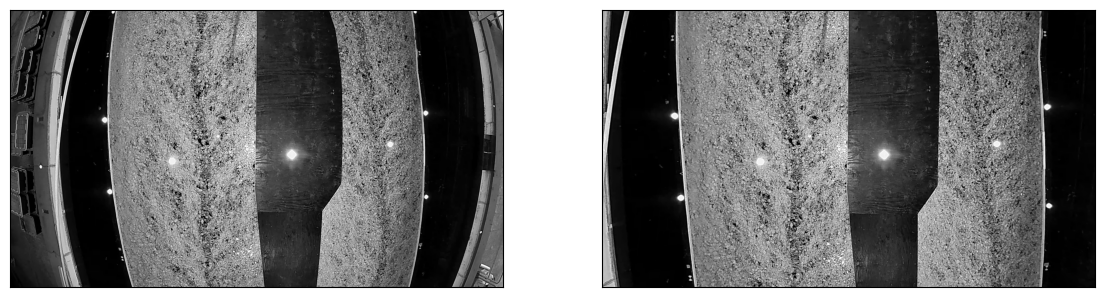

In [25]:
# Try not cropping the image when undistorting
for image_file in image_list:
    img = cv2.imread(image_file)

    h, w = img.shape[:2]
    # free scaling: alpha=1 keeps all pixels, alpha=0 crops to valid area
    img_undistorted = cv2.undistort(img, K, dist, None)

    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].imshow(img, cmap='Grays_r')
    ax[1].imshow(img_undistorted, cmap='Grays_r')
    for axis in ax:
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()

## Mapproject

In [10]:
os.makedirs(ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*_undistorted.tiff')))
cam_list = sorted(glob(os.path.join(undistorted_folder, '*.tsai')))

pbar = tqdm(total=len(img_list))
for img_file, cam_file in zip(img_list, cam_list):
    img_out_file = os.path.join(ortho_folder, os.path.basename(img_file).replace('.tiff', '_map.tiff'))
    cmd = [
        'mapproject',
        '--threads', '12',
        '--tr', '0.005',
        refdem_file, img_file, cam_file, img_out_file
    ]
    subprocess.run(cmd)
    pbar.update(1)

100%|██████████| 6/6 [08:44<00:00, 87.35s/it]


mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch01_main_20251001180000_20251001180626_undistorted_map.tiff --threads 12 --tr 0.005
	--> Setting number of processing threads to: 12
Using session: pinhole
Loading camera model: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch01_main_20251001180000_

 17%|█▋        | 1/6 [00:12<01:03, 12.77s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch01_main_20251001180000_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch01_main_20251001180000_20251001180626_undistorted_map.tiff
Finished in 9.837110996246338 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch02_main_20251001180001_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch02_main_20251001180001_20251001180626_un

 33%|███▎      | 2/6 [00:24<00:49, 12.37s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch02_main_20251001180001_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch02_main_20251001180001_20251001180626_undistorted_map.tiff
Finished in 9.341043949127197 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch03_main_20251001180002_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch03_main_20251001180002_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch03_main_20251001180002_20251001180626_un

 50%|█████     | 3/6 [00:37<00:36, 12.27s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch03_main_20251001180002_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch03_main_20251001180002_20251001180626_undistorted_map.tiff
Finished in 9.229131937026978 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch04_main_20251001180003_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch04_main_20251001180003_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch04_main_20251001180003_20251001180626_un

 67%|██████▋   | 4/6 [00:49<00:24, 12.20s/it]

.20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch04_main_20251001180003_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch04_main_20251001180003_20251001180626_undistorted_map.tiff
Finished in 9.167514085769653 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch05_main_20251001180004_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch05_main_20251001180004_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch05_main_20251001180004_20251001180626_undistort

 83%|████████▎ | 5/6 [01:00<00:11, 11.98s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch05_main_20251001180004_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch05_main_20251001180004_20251001180626_undistorted_map.tiff
Finished in 8.83759617805481 seconds.
mapproject_single --query-projection /Users/rdcrlrka/Research/Soo_locks/soo_locks_photogram/../inputs/20251001_Soo_Model_1cm_mean_UTM19N-fake_filled.tif /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch06_main_20251001180005_20251001180626_undistorted.tiff /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/undistorted_images/N910A6_ch06_main_20251001180005_20251001180626_undistorted.tsai /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch06_main_20251001180005_20251001180626_und

100%|██████████| 6/6 [01:12<00:00, 12.00s/it]

...10...20...30...40...50...60...70...80...90...100 - done.
Removing: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch06_main_20251001180005_20251001180626_undistorted_map_tiff_tiles/
Wrote: /Users/rdcrlrka/Research/Soo_locks/20251001_imagery/frames_IR_proc_out/ortho/N910A6_ch06_main_20251001180005_20251001180626_undistorted_map.tiff
Finished in 9.086344957351685 seconds.


## Stereo

## Generate initial camera models

In [ ]:
# def generate_cameras(image_list, gcp_list, cams_file, f_m=2.8*1e-3, gsd_m=2.5*1e-3, altitude_m=4.3):
#     # Load "lat-lon" camera positions
#     cams = pd.read_csv(
#         cams_file,
#         sep=' ',
#         header=None,
#         names=['img_name', 'lon', 'lat', 'Z', 'lon_std', 'lat_std']
#         )

#     # Estimate initial camera intrinsics in pixels
#     # convert focal length from mm to pixels
#     # GSD = (Altidude * Pixel Pitch) / Focal Length
#     # --> Pixel Pitch = (GSD * Focal Length) / Altitude
#     px_pitch = (gsd_m * f_m) / altitude_m
#     # Convert focal length to pixels to use a pitch of 1
#     f_px = f_m / px_pitch
#     print('Focal length (pixels):', f_px)

#     pbar = tqdm(total=len(image_list))
#     for image_file in image_list:
#         image_file_base = os.path.splitext(os.path.basename(image_file))[0].replace('_undistorted','')

#         # Subset camera positions
#         cam = cams.loc[cams['img_name'].str.contains(image_file_base)]

#         # Load GCP
#         gcp_file = [x for x in gcp_list if image_file_base in x]
#         if len(gcp_file) < 1:
#             raise ValueError(f"No GCP file found for image: {image_file}")
#         gcp = pd.read_csv(
#             gcp_file[0], 
#             sep=',', 
#             header=None,
#             names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std', 'img_name', 'sample_col', 'sample_row', 'use_Y', 'use_X']
#             )

#         # get "lat-lon" values and image pixel indices pairs
#         lonlat_str = [(str(lon),str(lat)) for lon,lat in gcp[['X', 'Y']].values]
#         lonlat_str = [' '.join(xy) for xy in lonlat_str]
#         lonlat_str = ', '.join(lonlat_str)

#         pxval_str = [(str(c),str(r)) for c,r in gcp[['sample_col', 'sample_row']].values]
#         pxval_str = [' '.join(xy) for xy in pxval_str]
#         pxval_str = ', '.join(pxval_str)

#         # Image dimensions
#         with rio.open(image_file) as src:
#             w_px = src.width
#             h_px = src.height

#         # Optical center
#         cu = w_px / 2
#         cv = h_px / 2

#         # construct command
#         cmd = [
#             'cam_gen',
#             # input image file
#             image_file,
#             '--threads', '12',
#             '--camera-type', 'pinhole',
#             '--refine-camera',
#             '--reference-dem', refdem_file,
#             # default height where DEM is NaN
#             '--height-above-datum', str(float(np.round(gcp['Z'].mean()))),
#             '--focal-length', str(f_px),
#             '--pixel-pitch', '1',
#             # horizontal, vertical components
#             '--optical-center', str(int(cu)), str(int(cv)),
#             # lon, lat, height
#             '--camera-center-llh', str(cam['lon'].values[0]), str(cam['lat'].values[0]), str(cam['Z'].values[0]),
#             '--lon-lat-values', lonlat_str,
#             '--pixel-values', pxval_str,
#             # output camera
#             '-o', os.path.join(
#                 cam_folder, 
#                 os.path.splitext(os.path.basename(image_file))[0] + '.tsai'
#                 ),
#         ]
#         subprocess.run(cmd)
#         pbar.update(1)

# os.makedirs(cam_folder, exist_ok=True)

# img_list = sorted(glob(os.path.join(undistorted_folder, '*_undistorted.tiff')))[0:6]
# gcp_list = sorted(glob(os.path.join(undistorted_folder, '*.gcp')))

# generate_cameras(img_list, gcp_list, cams_file)

## Align images to the lidar reflectance image using GCP

In [ ]:
os.makedirs(ba_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
gcp_list = sorted(glob(os.path.join(undistorted_folder, '*.gcp')))
cam_list = sorted(glob(os.path.join(cam_folder, '*.tsai')))

# run bundle_adjust in groups of two images for better optimization
for i in np.arange(0, len(img_list)-1, step=2):
    img1, img2 = img_list[i:i+2]
    cam1, cam2 = cam_list[i:i+2]
    gcp1, gcp2 = gcp_list[i:i+2]
    
    pair_prefix = os.path.join(
        ba_folder, 
        '__'.join([os.path.splitext(os.path.basename(x))[0] for x in (img1, img2)]),
        'run'
        )
    
    cmd = [
    'parallel_bundle_adjust',
        '-t', 'pinhole',
        '--threads', '12',
        '--num-iterations', '2000',
        '--num-passes', '2',
        # create new camera files
        '--inline-adjustments',
        '--heights-from-dem', refdem_file,
        '--heights-from-dem-uncertainty', '0.02',
        '--remove-outliers-params', "75.0 3.0 20 25",
        '-o', pair_prefix,
        img1, img2,
        cam1, cam2,
        gcp1, gcp2
    ]
    subprocess.run(cmd)


## Mapproject

In [ ]:
os.makedirs(init_ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*_undistorted.tiff')))
cam_list = sorted(glob(os.path.join(ba_folder, '*', '*.tsai')))

pbar = tqdm(total=len(img_list))
for img_file, cam_file in zip(img_list, cam_list):
    img_out_file = os.path.join(init_ortho_folder, os.path.basename(img_file).replace('.tiff', '_map.tiff'))
    cmd = [
        'mapproject',
        '--threads', '12',
        '--tr', '0.005',
        refdem_file, img_file, cam_file, img_out_file
    ]
    subprocess.run(cmd)
    pbar.update(1)

In [ ]:
# # align photos using the undistorted GCP
# gcp_list = sorted(glob(os.path.join(undistorted_folder, '*.gcp')))
# img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))

# def compute_georeferencing_transform(gcp_df):
#     """
#     Compute a similarity transform (rotation, scale, translation) from image pixels to UTM coords.
#     Returns an Affine transform object usable with rasterio.
#     """

#     # Use undistorted GCP pixel coordinates
#     img_pts = gcp_df[['sample_col_undist', 'sample_row_undist']].values.astype(np.float32)
#     world_pts = gcp_df[['X', 'Y']].values.astype(np.float32)

#     # Estimate similarity transform
#     M, inliers = cv2.estimateAffinePartial2D(img_pts, world_pts, method=cv2.LMEDS)

#     if M is None:
#         raise RuntimeError("Could not estimate transform.")

#     # Convert OpenCV affine matrix (2x3) to rasterio-style Affine
#     a, b, c = M[0]
#     d, e, f = M[1]

#     transform = Affine(a, b, c, d, e, f)
#     print(transform)
    
#     return transform


# os.makedirs(align_cv_folder, exist_ok=True)

# for gcp_file in tqdm(gcp_list[0:1]):
#     # open the GCP file
#     gcp = pd.read_csv(
#             gcp_file,
#             sep=' ',
#             header=None,
#             skiprows=[0],
#             engine='python',
#             names=['Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std',
#                     'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z', 'geometry',
#                     'sample_col_undist', 'sample_row_undist']
#         )
    
#     # get the image file name
#     img_name_base = os.path.splitext(os.path.basename(gcp.iloc[0]['img_path']))[0]
#     img_file = [x for x in img_list if img_name_base in x][0]

#     # load the original transform
#     img = rxr.open_rasterio(img_file).squeeze()
#     img_transform = img.rio.transform()

#     # estimate the alignment transform
#     align_transform = compute_georeferencing_transform(gcp)

#     # apply alignment transform to the original
#     img_transform_aligned = align_transform * img_transform

#     # apply the transform and CRS to a new DataArray
#     img_aligned = img.copy()
#     img_aligned.rio.write_transform(img_transform_aligned, inplace=True)
#     img_aligned.rio.write_crs(img.rio.crs, inplace=True)

#     # Save output
#     img_out_fn = os.path.join(align_cv_folder, os.path.basename(img_file).replace('.tiff', '_aligned.tiff'))
#     img_aligned.rio.to_raster(img_out_fn)

#     print('Aligned image saved to:', img_out_fn)
    

In [ ]:
# gcp = pd.read_csv(
#     gcp_list[3],
#     sep=' ',
#     header=None,
#     skiprows=[0],
#     engine='python',
#     names=['pt_idx', 'Y', 'X', 'Z', 'Y_std', 'X_std', 'Z_std',
#             'img_path', 'sample_col', 'sample_row', 'use_Y', 'use_X', 'use_Z', 'geometry', 'sample_col_undist', 'sample_row_undist']
# )

# # Reproject GCPs again
# gcp['geometry'] = [Point(x, y) for x, y in gcp[['X', 'Y']].values]
# gcp_gdf = gpd.GeoDataFrame(geometry=gcp['geometry'], crs="EPSG:4326")
# gcp_gdf = gcp_gdf.to_crs("EPSG:32619")
# gcp['X'] = gcp_gdf.geometry.x
# gcp['Y'] = gcp_gdf.geometry.y
# gcp['image_name'] = [os.path.basename(x) for x in gcp['img_path']]
# gcp.rename(columns={
#     'sample_col_undist': 'sample_col_undistorted',
#     'sample_row_undist': 'sample_row_undistorted'
# }, inplace=True)

# gcp = gcp[['X', 'Y', 'Z', 'image_name', 'sample_col', 'sample_row', 'sample_col_undistorted', 'sample_row_undistorted']]
# gcp_out = gcp_list[3].replace('.gcp', '.csv')
# gcp.to_csv(gcp_out, sep=',', header=True, index=False)

In [ ]:

# open orthoimage for plotting
ortho_file = os.path.join(os.getcwd(), 'inputs', '20251001_Soo_Model_5mm_Ground_Reflectance_UTM19N-fake.tif')
ortho = rxr.open_rasterio(ortho_file).squeeze()
ortho = ortho.data.astype(np.float32) # openCV only accepts up to 32-bit
ortho[ortho==-9999] = 0

# iterate over match files
for match_txt in match_txt_list[0:1]:
    match_txt_base = os.path.splitext(os.path.basename(match_txt).replace('run-',''))[0]

    # parse the image and ortho pixel coordinates
    match = pd.read_csv(match_txt, sep=' ', header=None, skiprows=[0])
    image_match_pts = match.iloc[0:int(len(match)/2)][[0,1]].values
    ortho_match_pts = match.iloc[int(len(match)/2):][[0,1]].values

    # open the image
    image_file = os.path.join(undistorted_folder, match_txt_base.split('__')[0] + '.tiff')
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    # align
    M, inliers = cv2.estimateAffine2D(np.array(image_match_pts), np.array(ortho_match_pts))
    


# Plot GCP / match points


# fig, ax = plt.subplots(1, 2, figsize=(10,5))
# ax[0].imshow(image, cmap='Grays_r')
# ax[1].imshow(ortho, cmap='Grays_r')
# for i in range(len(image_match)):
#     ax[0].plot(image_match.iloc[i][0], image_match.iloc[i][1], '*', markersize=8,
#                markerfacecolor=plt.cm.viridis(i/len(image_match)), markeredgecolor='w', markeredgewidth=0.3)
#     ax[1].plot(ortho_match.iloc[i][0], ortho_match.iloc[i][1], '*', markersize=8,
#                markerfacecolor=plt.cm.viridis(i/len(image_match)), markeredgecolor='w', markeredgewidth=0.3)
# ax[1].set_xlim(ortho_match[0].min() - 15, ortho_match[0].max() + 15)
# ax[1].set_ylim(ortho_match[1].max() + 15, ortho_match[1].min() - 15)
# for axis in ax:
#     axis.set_xticks([])
#     axis.set_yticks([])

# plt.show()

In [ ]:
h, w = image.shape[:2]

# Step 1: Transform source image corners
corners = np.array([
    [0, 0],
    [w, 0],
    [0, h],
    [w, h]
], dtype=np.float32)

# Convert corners to homogeneous coords
ones = np.ones((4, 1), dtype=np.float32)
corners_hom = np.hstack([corners, ones])

# Apply M to each corner
transformed_corners = (M @ corners_hom.T).T

# Step 2: Compute bounding box of warped image
x_min, y_min = np.min(transformed_corners, axis=0)
x_max, y_max = np.max(transformed_corners, axis=0)

width = int(np.ceil(x_max - x_min))
height = int(np.ceil(y_max - y_min))

# Step 3: Adjust M to shift output image to (0, 0)
translation = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min]
])

M_adjusted = translation @ np.vstack([M, [0, 0, 1]])  # make M 3x3 for matrix mult
M_adjusted = M_adjusted[:2, :]  # back to 2x3 for warpAffine

# Step 4: Warp image with adjusted matrix
warped = cv2.warpAffine(image, M_adjusted, (width, height), flags=cv2.INTER_LINEAR, borderValue=0)

ortho = rxr.open_rasterio(ortho_file).squeeze()
ortho = ortho.data.astype(np.float32) # openCV only accepts up to 32-bit
ortho[ortho==-9999] = 0

plt.imshow(warped)
plt.show()


In [ ]:
# # Add initial distortion coefficients
# cam_list = sorted(glob(os.path.join(cam_folder, '*.tsai')))

# for cam in tqdm(cam_list):
#     with open(cam, 'r') as f:
#         cam_lines = f.read().split('\n')
#     # remove empty lines
#     cam_lines = [x for x in cam_lines if x!='']

#     # replace the NULL with TSAI
#     for i, line in enumerate(cam_lines):
#         if 'NULL' in line:
#             cam_lines[i] = 'TSAI'

#     # add distortion coefficients
#     cam_lines += [
#         'k1 = -1e-6',
#         'k2 = 1e-6',
#         'p1 = 0',
#         'p2 = 0',
#         'k3 = 1e-6'
#     ]

#     cam_lines_string = '\n'.join(cam_lines) + '\n'
    
#     # write to file
#     with open(cam, 'w') as f:
#         f.write(cam_lines_string)

## Run stereo correlation for dense matches

In [ ]:
os.makedirs(init_stereo_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = [glob(os.path.join(cam_folder, '*' + os.path.splitext(os.path.basename(x))[0]) + '*.tsai')[0]
            for x in img_list]

img_pairs = list(zip(img_list[0:-1], img_list[1:]))
cam_pairs = list(zip(cam_list[0:-1], cam_list[1:]))

for i in tqdm(range(0,len(img_pairs))):
    img1, img2 = img_pairs[i]
    cam1, cam2 = cam_pairs[i]

    pair_prefix = os.path.join(
        init_stereo_folder,
        os.path.splitext(os.path.basename(img1))[0] + '__' + os.path.splitext(os.path.basename(img2))[0],
        'run'
        )

    cmd = [
        'parallel_stereo',
        '--threads-singleprocess', '12',
        '--threads-multiprocess', '12',
        '--stop-point', '1', # stop after feature detection and matching
        img1, img2,
        cam1, cam2,
        pair_prefix
    ]
    subprocess.run(cmd)

## Bundle adjust using dense matches

In [ ]:
os.makedirs(ba_folder, exist_ok=True)

cam_list = sorted(glob(os.path.join(cam_folder, '*.tsai')))
img_list = [os.path.join(new_img_folder, os.path.basename(x).replace('.tsai','.tiff')) 
            for x in cam_list]

# copy dense matches from stereo to bundle_adjust folder
match_list = glob(os.path.join(init_stereo_folder, '*', '*.match'))
print(f'Copying {len(match_list)} matches from stereo to the bundle adjust folder')
for match in tqdm(match_list):
    match_out = os.path.join(ba_folder, os.path.basename(match))
    _ = shutil.copy2(match, match_out)

cmd = [
    'parallel_bundle_adjust',
    '-t', 'pinhole',
    '--threads', '12',
    '--num-iterations', '2000',
    '--num-passes', '2',
    # create new camera files
    '--inline-adjustments',
    # more confident in the camera positions
    # '--camera-position-weight', '5',
    # use the matches from stereo
    '--force-reuse-match-files',
    # solve intrinsics
    # '--solve-intrinsics',
    # '--intrinsics-to-share', 'none',
    # '--intrinsics-to-float', 'all',
    '--heights-from-dem', refdem_file,
    '--heights-from-dem-uncertainty', '0.02',
    '--remove-outliers-params', "75.0 3.0 20 25",
    '-o', os.path.join(ba_folder, 'run'),
] + img_list + cam_list
subprocess.run(cmd)



## Initial orthorectification

In [ ]:
os.makedirs(init_ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = sorted(glob(os.path.join(ba_folder, '*.tsai')))

for img, cam in tqdm(list(zip(img_list, cam_list))):
    img_out_fn = os.path.join(init_ortho_folder, os.path.splitext(os.path.basename(img))[0] + '_map.tiff')
    cmd = [
        'mapproject',
        '--tr', '0.005',
        '--threads', '12',
        refdem_file, img, cam, img_out_fn
    ]
    subprocess.run(cmd)


## Final stereo

In [ ]:
os.makedirs(final_stereo_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(init_ortho_folder, '*.tiff')))
cam_list = [glob(os.path.join(ba_folder, '*' + os.path.splitext(os.path.basename(x))[0].replace('_map','')) + '*.tsai')[0]
            for x in img_list]

img_pairs = list(zip(img_list[0:-1], img_list[1:]))
cam_pairs = list(zip(cam_list[0:-1], cam_list[1:]))

for i in tqdm(range(0,len(img_pairs))):
    img1, img2 = img_pairs[i]
    cam1, cam2 = cam_pairs[i]

    pair_prefix = os.path.join(
        final_stereo_folder,
        os.path.splitext(os.path.basename(img1))[0] + '__' + os.path.splitext(os.path.basename(img2))[0],
        'run'
        )

    cmd = [
        'parallel_stereo',
        '--threads-singleprocess', '12',
        '--threads-multiprocess', '12',
        img1, img2,
        cam1, cam2,
        pair_prefix,
        refdem_file
    ]
    subprocess.run(cmd)

## Rasterize point clouds

In [ ]:
# Rasterize the point clouds
pc_files = sorted(glob(os.path.join(final_stereo_folder, '*', '*-PC.tif')))
print('Rasterizing the point clouds...')
for pc in tqdm(pc_files):
    cmd = [
        'point2dem',
        '--threads', '12',
        '--tr', '0.01',
        pc
    ]
    subprocess.run(cmd)

## Mosaic DEMs

In [ ]:
dem_fns = sorted(glob(os.path.join(final_stereo_folder, '*', '*DEM.tif')))
print('Creating mosaics of DEM using blended, median, NMAD, and count operators')
for method in tqdm(['median', 'nmad', 'count']):
    dem_fn = os.path.join(final_stereo_folder, f'DEM_mosaic_{method}.tif')
    cmd = [
        'dem_mosaic',
        '--threads', '12',
        '-o', dem_fn
    ] + dem_fns
    if method != 'blended':
        cmd += [f"--{method}"]
    subprocess.run(cmd)


## Align DEM mosaic with reference DEM

In [ ]:
dem_fn = os.path.join(final_stereo_folder, 'DEM_mosaic_median.tif')
os.makedirs(dem_align_folder, exist_ok=True)

cmd = [
    'pc_align',
    '--threads', '12',
    '--max-displacement', '3',
    '--save-transformed-source-points',
    refdem_file, dem_fn,
    '-o', os.path.join(dem_align_folder, 'run')
]
subprocess.run(cmd)

# Rasterize the aligned point cloud
pc_aligned_fn = os.path.join(dem_align_folder, 'run-trans_source.tif')
cmd = [
    'point2dem',
    '--threads', '12',
    '--tr', '0.01',
    pc_aligned_fn
]
subprocess.run(cmd)

## Align cameras

In [ ]:
os.makedirs(cam_align_folder, exist_ok=True)


def transform_pinhole_cameras(camera_file, transform_file, out_folder):
    # Read the camera file
    with open(camera_file, 'r') as f:
        camera_lines = f.read().split('\n')
    # get the camera center and rotation
    camera_C_line = [x for x in camera_lines if 'C =' in x][0]
    camera_C = np.array([float(x) for x in camera_C_line.split(' = ')[1].split(' ')])
    camera_R_line = [x for x in camera_lines if 'R = ' in x][0]
    camera_R = np.array([float(x) for x in camera_R_line.split(' = ')[1].split(' ')]).reshape(3,3)

    # Read the transform
    with open(transform_file, 'r') as f:
        transform_lines = f.read()
    # split by lines and spaces, convert to float, and reshape into 4x4
    transform_matrix = np.array([
        list(map(float, line.split()))
        for line in transform_lines.strip().split('\n')
    ])

    # Extract R and T from transform
    transform_R = transform_matrix[:3, :3]
    transform_T = transform_matrix[:3, 3]

    # Apply the transformation to camera
    camera_C_adj = transform_R @ camera_C + transform_T
    camera_R_adj = transform_R @ camera_R

    # Update the camera
    for i, line in enumerate(camera_lines):
        if 'C = ' in line:
            camera_C_adj_string = ' '.join(list(camera_C_adj.astype(str)))
            camera_lines[i] = f"C = {camera_C_adj_string}"
        elif 'R = ' in line:
            camera_R_adj_string = ' '.join(list(camera_R_adj.ravel().astype(str)))
            camera_lines[i] = f"R = {camera_R_adj_string}"

    
    # Save to file
    camera_lines_string = '\n'.join(camera_lines)
    camera_out_file = os.path.join(out_folder, os.path.basename(camera_file))
    with open(camera_out_file, 'w') as f:
        f.write(camera_lines_string)
    print('Transformed camera saved to file:', camera_out_file)

    return


cam_list = sorted(glob(os.path.join(ba_folder, '*.tsai')))
transform_fn = os.path.join(dem_align_folder, 'run-transform.txt')

for cam in tqdm(cam_list):
    transform_pinhole_cameras(cam, transform_fn, cam_align_folder)


## Mapproject images onto the reference DEM

In [ ]:
os.makedirs(final_ortho_folder, exist_ok=True)

img_list = sorted(glob(os.path.join(undistorted_folder, '*.tiff')))
cam_list = sorted(glob(os.path.join(cam_align_folder, '*.tsai')))

for img, cam in tqdm(list(zip(img_list, cam_list))):
    img_out_fn = os.path.join(final_ortho_folder, os.path.splitext(os.path.basename(img))[0] + '_map.tiff')
    cmd = [
        'mapproject',
        '--tr', '0.005',
        '--threads', '12',
        refdem_file, img, cam, img_out_fn
    ]
    subprocess.run(cmd)

## Mosaic mapprojected images

In [ ]:
img_list = sorted(glob(os.path.join(final_ortho_folder, '*_map.tiff')))
mosaic_fn = os.path.join(final_ortho_folder, 'orthomosaic.tif')
cmd = [
    'image_mosaic',
    '--threads', '12',
    '-o', mosaic_fn
] + img_list
subprocess.run(cmd)

## Plot results

In [ ]:
# Plot the ortho image and DEM mosaics
import matplotlib.pyplot as plt
import xarray as xr

fig_fn = os.path.join(out_folder, 'result.jpg')

# Load the input files
ortho_files = sorted(glob(os.path.join(final_ortho_folder, '*_map.tiff')))

dem_fn = os.path.join(dem_align_folder, 'run-trans_source-DEM.tif')
dem = rxr.open_rasterio(dem_fn).squeeze()
crs = dem.rio.crs
dem = xr.where(dem < -100, np.nan, dem)
dem = dem.rio.write_crs(crs)
refdem = rxr.open_rasterio(refdem_file).squeeze()
refdem = refdem.rio.reproject_match(dem)
refdem = xr.where(refdem < -100, np.nan, refdem)

plt.rcParams.update({'font.sans-serif': 'Verdana', 'font.size': 12})
fig, ax = plt.subplots(1, 3, figsize=(18,8))
# Ortho
for ortho_file in ortho_files:
    ortho = rxr.open_rasterio(ortho_file).squeeze()
    ortho = xr.where(ortho < -1e3, np.nan, ortho)
    ax[0].imshow(
        ortho, 
        cmap='Grays_r',
        extent=(min(ortho.x), max(ortho.x), min(ortho.y), max(ortho.y))
        )
ax[0].set_title('IR image mosaic')
# DEM
im = ax[1].imshow(
    dem, 
    cmap='terrain', 
    extent=(min(dem.x), max(dem.x), min(dem.y), max(dem.y), 'meters')
    )
cb = fig.colorbar(im, shrink=0.5)
ax[1].set_title('DSM mosaic')
# DEM - refdem
im = ax[2].imshow(
    dem - refdem, 
    cmap='coolwarm_r',
    clim=(-1,1),
    extent=(min(dem.x), max(dem.x), min(dem.y), max(dem.y))
    )
cb = fig.colorbar(im, shrink=0.5, label='meters')
ax[2].set_title('Lidar - DSM')

ax[0].set_xlim(ax[1].set_xlim())
ax[0].set_ylim(ax[1].get_ylim())

fig.tight_layout()
plt.show()

fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

In [ ]:
# Try 